In [1]:
%matplotlib inline
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter

from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import pandas as pd
idx = pd.IndexSlice
from scipy.stats.mstats import gmean
import statsmodels.api as sm
from statsmodels.formula.api import ols
import geopandas as gpd 
glob = pd.read_csv('data/index.csv').set_index(['country_code','field_code','method_code','period'])['value']
glob.loc[idx[:,:,['instTOP3'],:]] =  1 - glob.loc[idx[:,:,['instTOP3'],:]]
dists = pd.read_csv('../Phase2_CalcGlobalization/country_dists/country_dists_euclid.csv',index_col=['Country','field','method','period'])
usedIndicators = ['euclid','cosine','GiniSimpson','top3','instTOP3','shareEnglish','localShare']

classification = pd.read_csv('data/classification.csv',index_col='country_code')

fieldnames = {
    'top_Life':'Life sciences',
    'top_Health':'Health sciences',
    'top_Social':'Social sciences',
    'top_Physical':'Physical sciences',
}

methodnames = {
    'euclid':'Euclidian Distance',
    'cosine':'Cosine Distance',
    'GiniSimpson':'Gini-Simpson Index',
    'top3':'Largest Contributors Surplus',
    'instTOP3': 'Institutional Diversity',
    'shareEnglish': 'English Documents',
    'localShare':'Local Authors'
}

ccodes = [col for col in glob.index.get_level_values('country_code').unique() if not col.startswith('_')]
flds_narrow = [col for col in glob.index.get_level_values('field_code').unique() if col.startswith('bot')]
flds_broad = [col for col in glob.index.get_level_values('field_code').unique() if col.startswith('top') or col == 'All']

## Results

## The life sciences and physical sciences are more globalized than social sciences and health sciences

## Table 2: Correlation matrix

In [2]:
corr_full = glob.unstack('method_code').corr()
corr_full.loc[usedIndicators,usedIndicators]

method_code,euclid,cosine,GiniSimpson,top3,instTOP3,shareEnglish,localShare
method_code,,,,,,,
euclid,1.000000,0.830449,0.874059,0.930774,0.810180,0.605488,0.751355
cosine,0.830449,1.000000,0.635853,0.753335,0.685516,0.468807,0.412670
GiniSimpson,0.874059,0.635853,1.000000,0.720117,0.667909,0.643782,0.783917
top3,0.930774,0.753335,0.720117,1.000000,0.787058,0.510800,0.674129
instTOP3,0.810180,0.685516,0.667909,0.787058,1.000000,0.426333,0.571730
shareEnglish,0.605488,0.468807,0.643782,0.510800,0.426333,1.000000,0.606302
localShare,0.751355,0.412670,0.783917,0.674129,0.571730,0.606302,1.000000


## Figure 1: Globalization score - Euclid, 2017, total

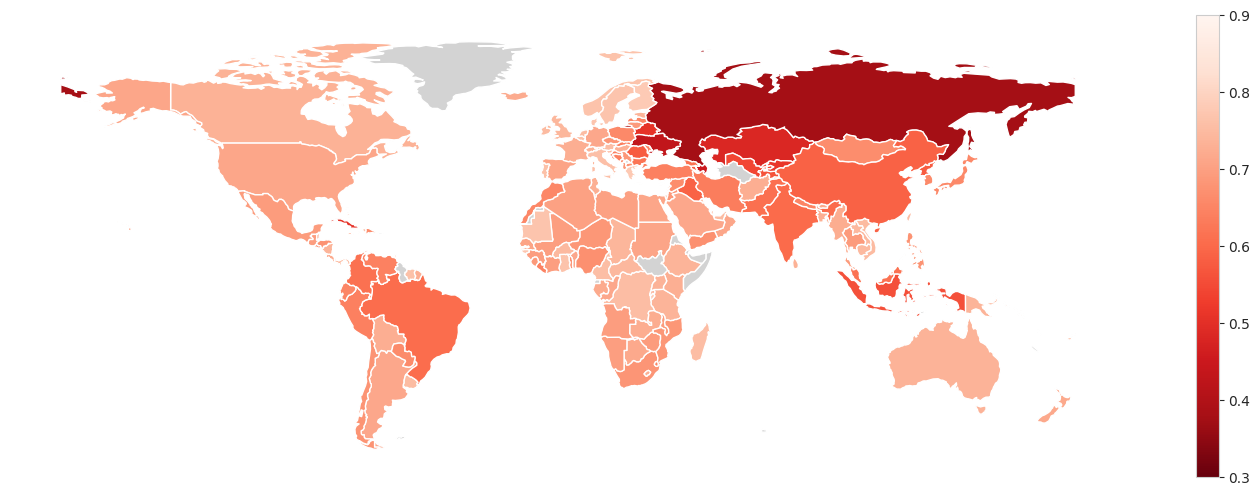

In [3]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
world = world[world.name != 'Antarctica']
world_data = glob.loc[idx[ccodes, 'All','euclid',2017 ]].reset_index(level=['field_code','method_code','period'],drop=True).to_frame()
world_data
world = world.merge(world_data,left_on='iso_a3',right_index=True,how='left')
ax = world.plot(column='value',figsize=(18,6),cmap='Reds_r',vmax=.9,vmin=.3,legend=True,missing_kwds={"color": "lightgrey"})
ax.set_axis_off();
plt.savefig('figs/fig1.pdf')

## Figure 2. Distribution of scores across indicators and country groups, 2017. 

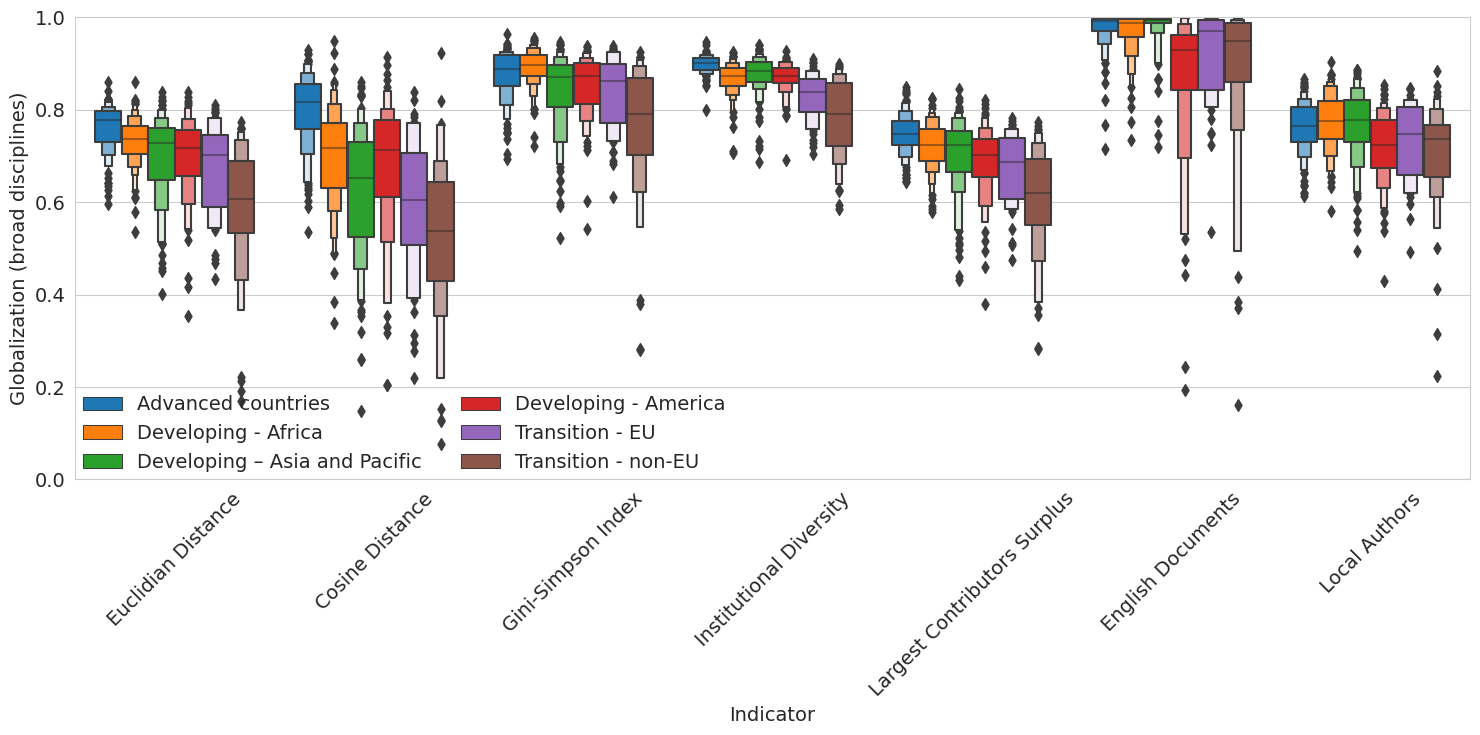

In [4]:
groups = glob.loc[idx[ccodes,flds_broad[:-1],:,2017]].reset_index()
groups['classification'] = groups.country_code.map(classification.classification)
groups['methods'] = groups.method_code.map(methodnames)

plt.figure(figsize=(18,6))
sns.boxenplot(x='methods',
            y='value',
            hue='classification',
            hue_order=['Advanced countries','Developing - Africa','Developing – Asia and Pacific','Developing - America','Transition - EU','Transition - non-EU'],
            #order=['Advanced countries','Developing countries','Transition countries'],
            saturation=1,
            data=groups)
plt.legend(frameon=False,fontsize=14,loc=(0,0),ncol=2)
plt.ylim((0,1))
plt.xticks(fontsize=14,rotation=45)
plt.yticks(fontsize=14)
plt.ylabel('Globalization (broad disciplines)',fontsize=14);
plt.xlabel('Indicator',fontsize=14)
plt.savefig('figs/fig2.pdf',bbox_inches='tight');

## Figure 3: Distribution of scores across country groups and broad disciplines, 2015-2017

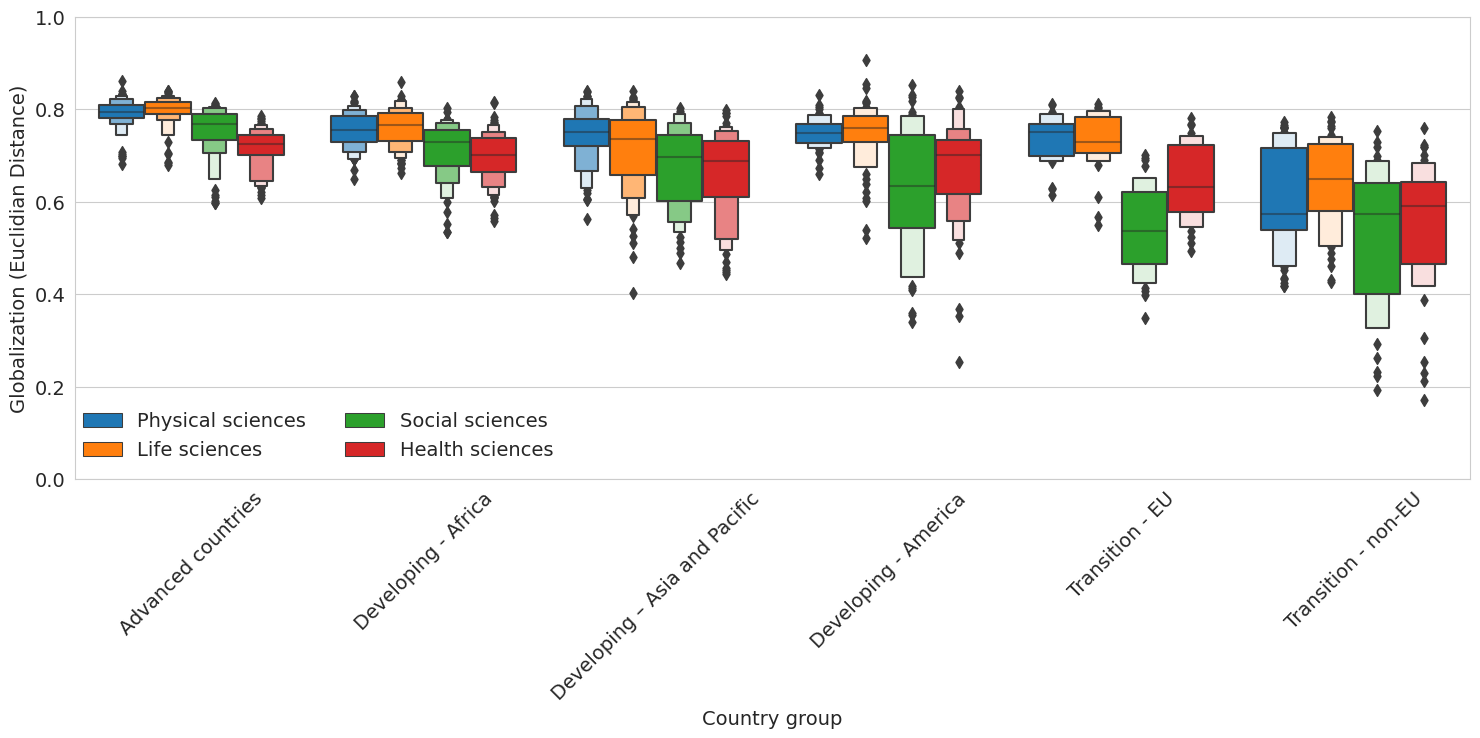

In [5]:
groups = glob.loc[idx[ccodes,flds_broad[:-1],'euclid',[2015,2016,2017]]].reset_index()
groups['classification'] = groups.country_code.map(classification.classification)
groups['fields'] = groups.field_code.map(fieldnames)

plt.figure(figsize=(18,6))
sns.boxenplot(x='classification',
            y='value',
            hue='fields',
            order=['Advanced countries','Developing - Africa','Developing – Asia and Pacific','Developing - America','Transition - EU','Transition - non-EU'],
            hue_order=['Physical sciences','Life sciences','Social sciences', 'Health sciences'],
            saturation=1,
            data=groups)
plt.legend(frameon=False,fontsize=14,loc=(0.0,0.025),ncol=2)
plt.ylim((0,1))
plt.xticks(fontsize=14,rotation=45)
plt.yticks(fontsize=14)
plt.ylabel('Globalization (Euclidian Distance)',fontsize=14);
plt.xlabel('Country group',fontsize=14)
plt.savefig('figs/fig3.pdf',bbox_inches='tight');

### Figure 4: Distribution of documents into journals by globalization quartiles in Social sciences in the EU countries (Euclidian distance, 2017)

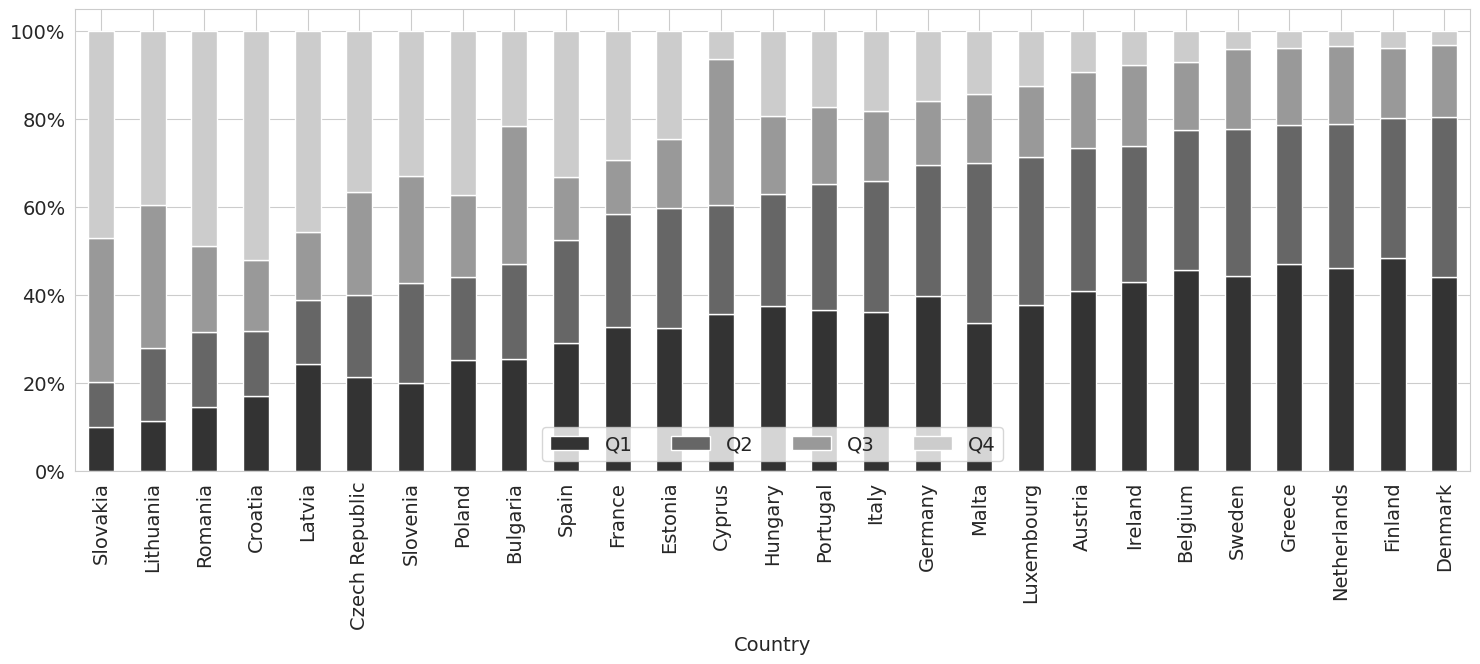

In [7]:
eu_countries = ['Bulgaria', 'Croatia', 'Czech Republic', 'Estonia', 'Hungary', 'Latvia', 'Lithuania', 'Poland', 'Romania', 'Slovakia', 'Slovenia', 'Austria',
                'Belgium', 'Cyprus', 'Denmark', 'Finland', 'France', 'Germany', 'Greece', 'Ireland', 'Italy', 'Luxembourg', 'Netherlands', 'Portugal',
                'Spain', 'Sweden', 'Malta']

pct_formatter = FuncFormatter(lambda x,pos: f'{round(x*100)}%')
grey_colors=[(.2,.2,.2,1),(.4,.4,.4,1),(.6,.6,.6,1),(.8,.8,.8,1)]

eu_dists = dists.loc[idx[eu_countries,['top_Social'],:,2017],['Q1','Q2','Q3','Q4']].reset_index(level=['method','field','period'],drop=True)
eu_dists['H'] = eu_dists.Q1 + eu_dists.Q2
eu_dists = eu_dists.sort_values('H').drop('H',axis=1)
ax = eu_dists.plot.bar(stacked=True,figsize=(18,6),color=grey_colors,fontsize=14)
ax.legend(ncol=4,loc='lower center',fontsize=14)
ax.yaxis.set_major_formatter(pct_formatter)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('Country',fontsize=14)
plt.savefig('figs/fig4.pdf' ,bbox_inches='tight');

## Figure 5: Globalization scores in BRIICS and other large countries over time, Euclidian distance

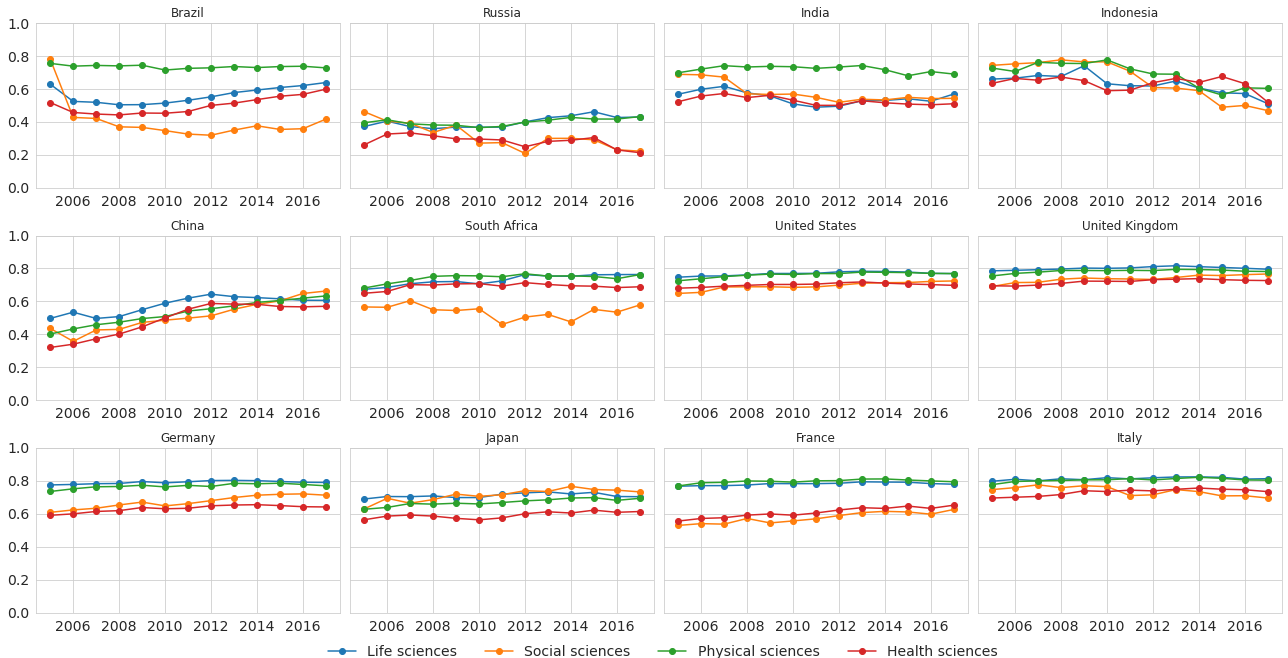

In [7]:
fig, axs = plt.subplots(ncols=4,nrows=3,figsize=(18,9),sharex=False,sharey=True)
axs = axs.flatten()
big_countries = ['BRA','RUS','IND','IDN',
    'CHN','ZAF','USA','GBR',
    'DEU','JPN','FRA','ITA']

for i,code in enumerate(big_countries):
    subset = glob.loc[idx[code,flds_broad[:-1],'euclid']].unstack('field_code').reset_index(level=['method_code','country_code'],drop=True).rename(fieldnames,axis=1)
    
    axs[i] = subset.plot(ax=axs[i],legend=False,title=classification.loc[code,'name'],fontsize=14,ylim=(0,1),style='o-')
    axs[i].set_xlabel('')
handles, labels = axs[i].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.25,-0.01),ncol=4,frameon=False,fontsize=14)
fig.tight_layout()
plt.savefig('figs/fig5.pdf',bbox_inches='tight');

## Figure 6: Breakdown of research output across disciplines in China between 2005 – 2017 (Euclidian distance)

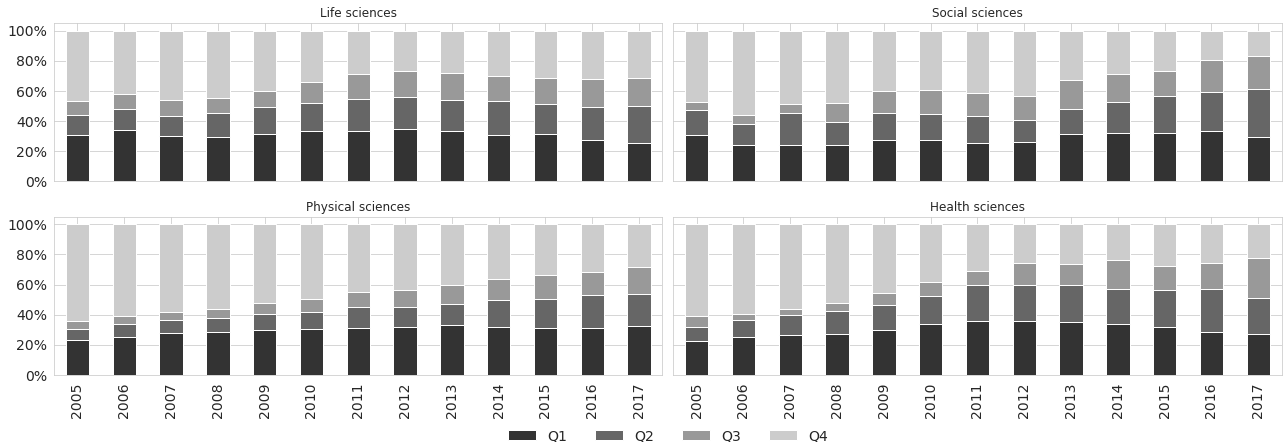

In [8]:
fig, axs = plt.subplots(ncols=2,nrows=2,figsize=(18,6),sharex=True,sharey=True)
axs = axs.flatten()

for i,field in enumerate(flds_broad[:-1]):
    subset = dists.loc[idx['China',field,:],['Q1','Q2','Q3','Q4']].reset_index(level=['Country','field','method'],drop=True)
    subset.plot.bar(stacked=True,ax=axs[i],legend=False,title=fieldnames[field],color=grey_colors,fontsize=14)
    axs[i].yaxis.set_major_formatter(pct_formatter)
    axs[i].set_xlabel('')

#axs[0].legend(ncol=4,loc='upper center',fontsize=12)
handles, labels = axs[i].get_legend_handles_labels()
fig.legend(handles, labels, loc=(0.39,-0.015),ncol=4,frameon=False,fontsize=14)
fig.tight_layout()
plt.savefig('figs/fig6.pdf',bbox_inches='tight');

## Output CSVs as an appendix

In [9]:
glob.to_csv('../public_data/globalization_scores.csv',header=True)
classification.to_csv('../public_data/classification.csv',header=True)
dists.to_csv('../public_data/globalization_quartiles.csv')

## Appendix A4: IMF (2003) country classification 

In [10]:
for group in classification.classification.unique():
    l = list(classification[classification.classification == group].name)
    l.sort()
    print('{}: '.format(group) + ', '.join(l) + '\n')

Developing - Africa: Algeria, Angola, Benin, Botswana, Burkina Faso, Burundi, Cameroon, Cape Verde, Central African Republic, Chad, Congo, Cote d'Ivoire, Democratic Republic Congo, Egypt, Eritrea, Ethiopia, Gabon, Gambia, Ghana, Guinea, Guinea-Bissau, Kenya, Lesotho, Liberia, Libya, Madagascar, Malawi, Mali, Mauritania, Mauritius, Morocco, Mozambique, Namibia, Niger, Nigeria, Rwanda, Saudi Arabia, Senegal, Seychelles, Sierra Leone, South Africa, Sudan, Swaziland, Tanzania, Togo, Tunisia, Uganda, Zambia, Zimbabwe

Developing - America: Argentina, Bahamas, Barbados, Belize, Bolivia, Brazil, Chile, Colombia, Costa Rica, Cuba, Dominica, Dominican Republic, Ecuador, El Salvador, Grenada, Guatemala, Guyana, Haiti, Honduras, Jamaica, Mexico, Nicaragua, Panama, Paraguay, Peru, Saint Kitts and Nevis, Suriname, Trinidad and Tobago, Uruguay, Venezuela

Transition - non-EU: Albania, Armenia, Azerbaijan, Belarus, Bosnia and Herzegovina, Georgia, Kazakhstan, Kyrgyzstan, Macedonia, Moldova, Mongolia,

## ANOVA

In [11]:
# Calculating effect size
def anova_table(df,formula):
    model  = ols(formula, df).fit()
    aov = sm.stats.anova_lm(model, typ=2)
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov,model

d = {}

formula = 'value ~ C(country_code) + \
                   C(field_code) + \
                   C(period)'# + \
                #   C(country_code)*C(field_code)'# + \
                #    C(country_code)*C(period) + \
                #    C(field_code)*C(period) + \
                #    C(field_code)*C(period)*C(country_code)'
for method in tqdm(usedIndicators):
    df_narrow = glob.loc[idx[ccodes,flds_narrow,method,:]].to_frame().reset_index()
    anova_narrow, model_narrow = anova_table(df_narrow,formula)
    tbl_narrow = anova_narrow['omega_sq']
    tbl_narrow['r_squared'] = model_narrow.rsquared
    d[('narrow',method)] = tbl_narrow
    #d[('narrow','omega_sq',method)] = anova_table(df_narrow,formula)['omega_sq'].sum()
    #d[('narrow','r_sq',method)] = ols(formula,df_narrow).fit().rsquared

    df_broad = glob.loc[idx[ccodes,flds_broad,method,:]].to_frame().reset_index()
    anova_broad, model_broad = anova_table(df_broad,formula)
    tbl_broad = anova_broad['omega_sq']
    tbl_broad['r_squared'] = model_broad.rsquared
    d[('broad',method)] = tbl_broad

#anova_cntr_fld_time = pd.Series(d).unstack()#.stack(0).reorder_levels((1,0)).sort_index()
anova_cntr_fld_time = pd.DataFrame(d).stack(0).reorder_levels((1,0)).sort_index()

anova_cntr_fld_time

100%|██████████| 7/7 [00:24<00:00,  3.52s/it]


GiniSimpson    cosine    euclid  instTOP3  localShare  \
broad  C(country_code)     0.554021  0.674688  0.575939  0.638360    0.373066   
       C(field_code)       0.135900  0.040550  0.109370  0.039870    0.233713   
       C(period)           0.026477  0.002562  0.002047  0.008985    0.042285   
       r_squared           0.722761  0.721544  0.691047  0.691651    0.659132   
narrow C(country_code)     0.360881  0.464108  0.362330  0.422046    0.182895   
       C(field_code)       0.201638  0.161315  0.225895  0.177003    0.343008   
       C(period)           0.011125  0.001613  0.000653  0.003926    0.022992   
       r_squared           0.570292  0.620948  0.582070  0.598052    0.559700   

                        shareEnglish      top3  
broad  C(country_code)      0.471126  0.532574  
       C(field_code)        0.101925  0.086131  
       C(period)            0.016905  0.002646  
       r_squared            0.598732  0.629452  
narrow C(country_code)      0.276404  0.311592  
       C(field_code)        0.141780  0.244920  
       C(period)            0.006361  0.002568  
       r_squared            0.425486  0.558794